## ANLP Assignment 1: Sentiment Analysis
### Shuying Piao,  id: a1912828

In [ ]:
# Load libraries and packages
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Concatenate, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Set up the randomseed
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### 1. Reading dataset and initial pre-processing

In [3]:
# Reading the dataset:title, text and ratings
df = pd.read_json('hotel_reviews_train.JSON', lines=True)
df = df[['title','text','ratings']]
df['ratings'] = df['ratings'].apply(lambda x:x.get("overall"))
df.columns = ['title', 'text','overall_ratings']
df['text'] = df['title'] + " " + df['text'] 
df = df.drop(columns=['title'])

print("Original Data:\n")
display(df.head())


# Initialize the spaCy model
nlp = spacy.load('en_core_web_sm')

# Define the preprocessing function
def preprocess_data(df):
    
    # Clean special symbols
    def clean_special_symbols(text):
        if not isinstance(text, str):
            return ""
        return re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Apply the clean data function for removing special characters
    df['text'] = df['text'].apply(clean_special_symbols)

    # Convert to lowercase
    df['text'] = df['text'].str.lower()

    # Tokenization
    nltk.download('punkt_tab')
    df['text'] = df['text'].apply(word_tokenize)

    # Remove stop words
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    df['text'] = df['text'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

    # Lemmatization
    def lemmatize(tokens):
        doc = nlp(' '.join(tokens))
        lemmatized_tokens = [token.lemma_ for token in doc]
        return lemmatized_tokens

    df['text'] = df['text'].apply(lemmatize)

    return df


# Preprocess the data
df = preprocess_data(df)

# Display the processed data
print("After Preprocessing Data:\n")
display(df.head())
print(len(df))


Original Data:



,text,overall_ratings
0,“Horrible experience” First of all we got ther...,1.0
1,“Stay Away” Found Racist graffiti in the room....,1.0
2,“Great location and service” Close to Union Sq...,4.0
3,“I will never go back here again!” I had a bad...,2.0
4,“Ripped off our VISA card after departure” Aft...,1.0


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pushuying/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pushuying/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


After Preprocessing Data:



,text,overall_ratings
0,"[horrible, experience, first, get, did, not, r...",1.0
1,"[stay, away, find, racist, graffiti, room, req...",1.0
2,"[great, location, service, close, union, squar...",4.0
3,"[never, go, back, bad, vibe, place, moment, wa...",2.0
4,"[rip, visa, card, departure, receive, final, b...",1.0


24000


In [4]:
# Extract the text and overall ratings from the test set, and align the format with the training set
df_test = pd.read_json("hotel_reviews_test.JSON", lines=True)
display(df_test)
df_test = df_test[['title','text','ratings']]
df_test['ratings'] = df_test['ratings'].apply(lambda x:x.get("overall"))
df_test.columns = ['title', 'text','overall_ratings']
df_test['text'] = df_test['title'] + " " + df_test['text'] 
df_test = df_test.drop(columns=['title'])
df_test_clean = preprocess_data(df_test)
display(df_test_clean)

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“I was SO surprised! I WILL return!”,My husband and I just celebrated our 25th wedd...,"{'username': 'shooflyfarm', 'num_cities': 15, ...",November 2011,1783324,1,2011-11-26,121063682,False
1,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“A Mother/Daughter vacation”,I could not leave a bad comment on any part of...,"{'username': 'bestmpm', 'num_reviews': 1, 'id'...",August 2011,88458,0,2011-08-10,116545869,False
2,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Good Choice for Pre-cruise”,I spent one night at this hotel prior to a cru...,"{'username': 'Conner2dood', 'num_cities': 20, ...",November 2010,82868,0,2010-12-06,89196759,False
3,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“Unsung Hero”,"For the past year and a half, my daughter has ...","{'username': 'LeviK', 'num_reviews': 2, 'num_c...",July 2011,98979,0,2011-07-28,115879719,False
4,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Great Value for a King, Queen, and Princesses.”","Great Value for a King, Queen, and Princesses....","{'username': 'thomrho', 'num_cities': 13, 'num...",March 2007,112273,8,2007-03-21,7198417,False
...,...,...,...,...,...,...,...,...,...,...
5995,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Felt right at home here”,I've stayed at many downtown Chicago hotels. T...,"{'username': 'eyemdphd', 'num_cities': 9, 'num...",April 2012,217498,3,2012-05-01,129203990,False
5996,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Days Inn Chicago 101212”,It is always a pleasant stay at your facility....,"{'username': 'ROBERT S', 'num_reviews': 1, 'id...",October 2012,87571,0,2012-10-22,143435143,False
5997,"{'service': 2.0, 'cleanliness': 3.0, 'overall'...",“Upgrades Needed”,We recently stayed here for a girls' weekend. ...,"{'username': 'Daisy M', 'num_reviews': 1, 'id'...",January 2012,223022,0,2012-01-30,123834976,False
5998,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“perfect bargain city hotel”,I made my reservation online at the Bijou beca...,"{'username': 'doublemet', 'num_reviews': 1, 'i...",May 2010,80920,1,2010-05-30,65827506,False


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pushuying/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pushuying/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,overall_ratings
0,"[surprised, return, husband, celebrate, 25th, ...",5.0
1,"[motherdaughter, vacation, could, leave, bad, ...",5.0
2,"[good, choice, precruise, spend, one, night, h...",4.0
3,"[unsung, hero, past, year, half, daughter, fig...",5.0
4,"[great, value, king, queen, princesse, great, ...",5.0
...,...,...
5995,"[feel, right, home, I, ve, stay, many, downtow...",5.0
5996,"[day, inn, chicago, 101212, always, pleasant, ...",5.0
5997,"[upgrade, need, recently, stay, girl, weekend,...",2.0
5998,"[perfect, bargain, city, hotel, make, reservat...",5.0


### 2. Exploratory Data Analysis (EDA)

In [5]:
df_original = df.copy()

# Check for null values and duplicated rows
print(df.isnull().sum())

# If 'text' is a list of tokens, join them into a signle to prepare for duplication check
df_original['text'] = df_original['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
print(df_original.duplicated().sum())

# Count the number of duplicated rows
df_original = df_original.drop_duplicates()
print(df_original.duplicated().sum())


text               0
overall_ratings    0
dtype: int64
1
0


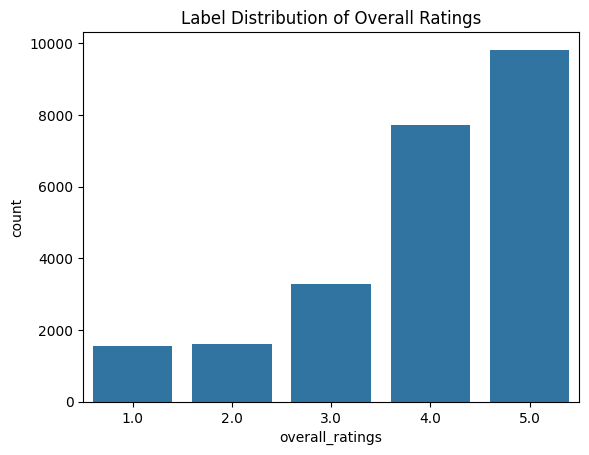

In [6]:
# Distribution of ratings over instances
import seaborn as sns
import matplotlib.pyplot as plt


# Visualize the distribution of overall rating labels
sns.countplot(x='overall_ratings', data=df_original)
plt.title('Label Distribution of Overall Ratings')
plt.show()


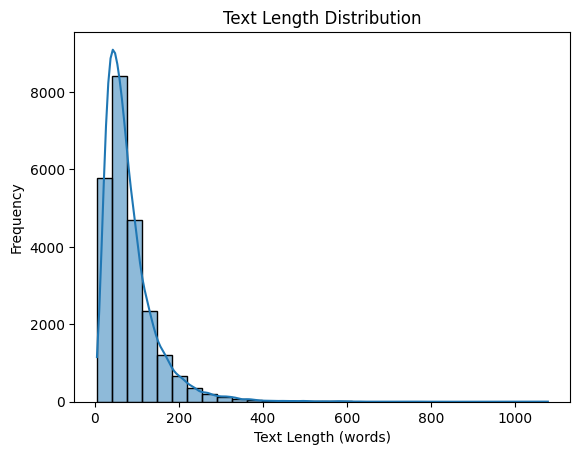

In [7]:
# Analyze and visualize the distribution of text lengths (measured in number of words)
df_original['text_length'] = df_original['text'].apply(lambda x: len(x.split()))
sns.histplot(df_original['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.show()


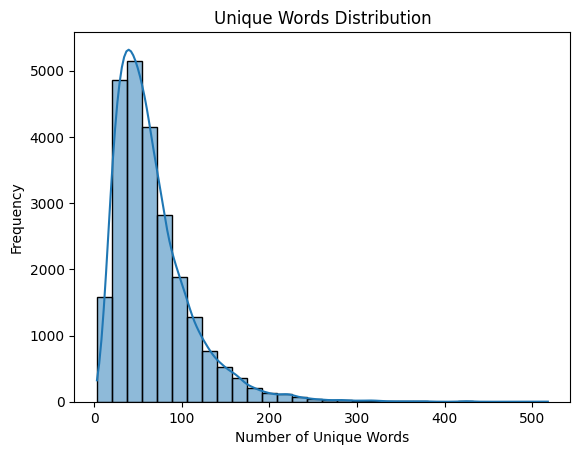

23999


,text,overall_ratings,text_length,unique_words
0,horrible experience first get did not room boo...,1.0,113,87
1,stay away find racist graffiti room request ch...,1.0,36,30
2,great location service close union square hote...,4.0,34,32
3,never go back bad vibe place moment walk main ...,2.0,148,117
4,rip visa card departure receive final bill lea...,1.0,28,24
...,...,...,...,...
23995,pleasant stay good location stay one night vis...,4.0,57,47
23996,hit miss thing need attention spend two night ...,3.0,188,147
23997,good breakfast room fairly large pretty quiet ...,5.0,15,13
23998,deserve high rating great start stay check 2hr...,4.0,60,58


,text,overall_ratings,text_length,unique_words


Series([], Name: text, dtype: object)

In [ ]:
# Count the number of unique words
df_original['unique_words'] = df_original['text'].apply(lambda x: len(set(x.split())))
sns.histplot(df_original['unique_words'], bins=30, kde=True)
plt.title('Unique Words Distribution')
plt.xlabel('Number of Unique Words')
plt.ylabel('Frequency')
plt.show()

print(len(df_original['unique_words']))

# Filter and display samples with 5 to 300 unique words (normal/valid text range)
df_new =  df_original[(df_original['unique_words'] >= 5) & (df_original['unique_words'] <= 300)]
display(df_new)
df_new['text']

# Filter and display samples with fewer than 5 or more than 300 unique words
# to inspect unusual/edge-case text samples
df_new =  df_original[(df_original['unique_words'] < 5) & (df_original['unique_words'] > 300)]
display(df_new)
df_new['text']


Most Common Words:
 [('hotel', 52783), ('room', 49982), ('stay', 31629), ('great', 22345), ('not', 18504), ('good', 16504), ('staff', 16502), ('location', 15390), ('would', 14529), ('get', 14197), ('nice', 13419), ('night', 12802), ('one', 11674), ('clean', 11373), ('time', 10941), ('service', 10670), ('well', 10431), ('bed', 10364), ('do', 10343), ('go', 10314)]


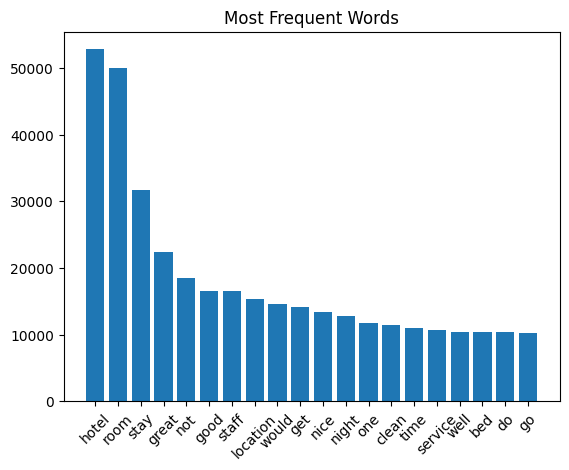

In [9]:

# Analyze most frequent words

from collections import Counter

# Tokenize the text and get word frequency
df_original['tokens'] = df_original['text'].apply(word_tokenize)
all_tokens = [token for tokens in df_original['tokens'] for token in tokens]
word_freq = Counter(all_tokens)

# Display top 20 most frequent words
most_common_words = word_freq.most_common(20)
print("Most Common Words:\n", most_common_words)

# Visualize the most common words
labels, values = zip(*most_common_words)
plt.bar(labels, values)
plt.xticks(rotation=45)
plt.title('Most Frequent Words')
plt.show()


In [10]:
# Identify predictive keywords(TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=20)
X_tfidf = vectorizer.fit_transform(df_original['text'])

# Get the top 20 features (keywords) based on TF-IDF
features = vectorizer.get_feature_names_out()
print("Top 20 TF-IDF Features:\n", features)

Top 20 TF-IDF Features:
 ['bed' 'clean' 'do' 'get' 'go' 'good' 'great' 'hotel' 'location' 'nice'
 'night' 'not' 'one' 'room' 'service' 'staff' 'stay' 'time' 'well' 'would']


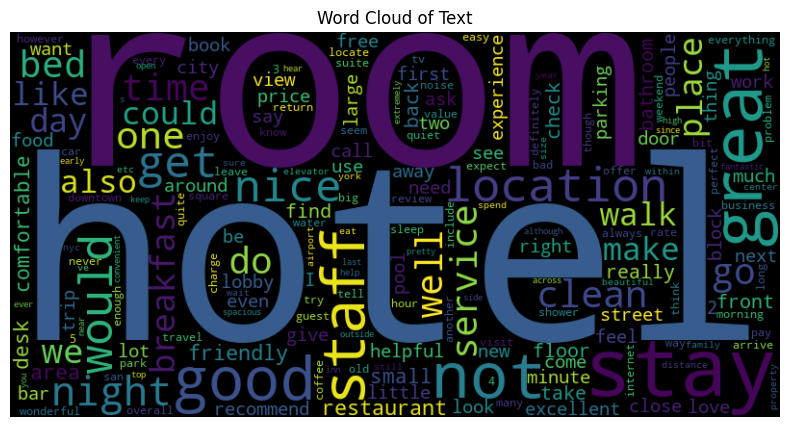

In [11]:
# Wordcloud

from wordcloud import WordCloud

# Create a wordcloud of the most common words
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text')
plt.show()

In [12]:
# Analyze rare words(appearing only once)
rare_words = [word for word, count in word_freq.items() if count == 1]
print(len(rare_words))

print(f"Rare words (appearing once):\n{rare_words[:30]}")



28529
Rare words (appearing once):
['swastikas', 'racism', 'funcational', 'withhold', 'alternatle', 'humorously', 'airporrt', 'waw', 'sqmacys', 'msg5th', 'avea', 'degreeswe', 'saunaheaven', 'streetsa', 'anywayand', '350which', 'bucketfor', 'zeigfeld', 'theatreit', 'iceskating', '35it', 'middnight', 'levain', 'julianne', 'proficent', 'avenueinternet', 'shhh', 'upthey', 'treatand', 'rightoff']


In [13]:
# Check for the stucture of data 
display(df_original)

,text,overall_ratings,text_length,unique_words,tokens
0,horrible experience first get did not room boo...,1.0,113,87,"[horrible, experience, first, get, did, not, r..."
1,stay away find racist graffiti room request ch...,1.0,36,30,"[stay, away, find, racist, graffiti, room, req..."
2,great location service close union square hote...,4.0,34,32,"[great, location, service, close, union, squar..."
3,never go back bad vibe place moment walk main ...,2.0,148,117,"[never, go, back, bad, vibe, place, moment, wa..."
4,rip visa card departure receive final bill lea...,1.0,28,24,"[rip, visa, card, departure, receive, final, b..."
...,...,...,...,...,...
23995,pleasant stay good location stay one night vis...,4.0,57,47,"[pleasant, stay, good, location, stay, one, ni..."
23996,hit miss thing need attention spend two night ...,3.0,188,147,"[hit, miss, thing, need, attention, spend, two..."
23997,good breakfast room fairly large pretty quiet ...,5.0,15,13,"[good, breakfast, room, fairly, large, pretty,..."
23998,deserve high rating great start stay check 2hr...,4.0,60,58,"[deserve, high, rating, great, start, stay, ch..."


#### EDA Discussion:

Based on the results of my exploratory data analysis, I’ve made the following key observations and decisions for data preprocessing:
1.	Imbalanced labels: The rating distribution is not balanced, especially between ratings 1/2 and 5. To prevent the model from favoring the more frequent labels, I will use sampling methods to balance the dataset.
2.	Text length: Most reviews have between 50 and 150 words. To make model input more consistent, I will set a maximum word limit, cut off very long reviews, and remove reviews with fewer than 5 words. Since I will use both traditional machine learning and deep learning models, I will only pad the text for deep learning models, and skip this step for traditional models.
3.	Number of unique words: I looked at how many different words are in each review to check how rich the content is. If a review has too few words, it might not have useful information. If it has too many, it could be too noisy. I didn’t find any extreme cases (like fewer than 5 or more than 300 unique words), so I won’t make changes here.
4.	High-frequency words and TF-IDF: Using a word cloud and word frequency count, I found the 20 most common words. Words like “hotel” and “room” appear often because of the topic, but they may not help much in telling the review’s sentiment. However, “room” has a high TF-IDF score, meaning it can be useful in context. So, I will keep “room” and reduce the importance of “hotel” when using Word2Vec word vectors.
5.	Low-frequency words: I looked at words that appear only once. Most of them seem to be spelling mistakes. At first, I thought about correcting them, but it takes too much time. In the end, I decided to just remove these rare words.

In [14]:
# Remove rare words from each token list
df_original['tokens'] = df_original['tokens'].apply(lambda tokens: [word for word in tokens if word not in rare_words])

In [15]:
max_len = 300
min_len = 5


# Truncate overly long texts, filter out overly short ones
df_original['tokens'] = df_original['tokens'].apply(lambda x: x[:max_len] if len(x) > max_len else x)
df_original = df_original[df_original['tokens'].apply(lambda x: len(x) >= min_len)].reset_index(drop=True)


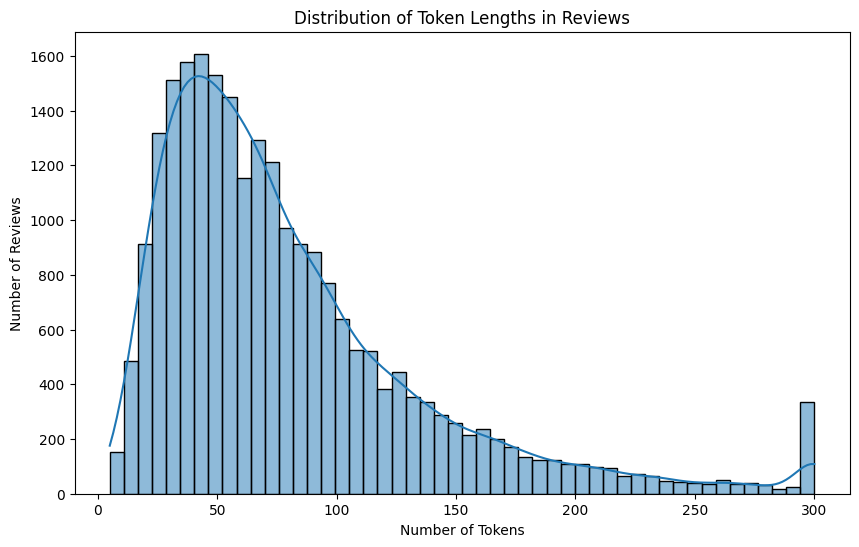

In [16]:
# Visualize the distribution of review lengths after truncation and filtering
df_original['token_len'] = df_original['tokens'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df_original['token_len'], bins=50, kde=True)
plt.title('Distribution of Token Lengths in Reviews')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Reviews')
plt.show()

In [17]:
# Word to vector(Word2Vec)
from gensim.models import Word2Vec

# Convert words into vector representations
model = Word2Vec(df_original['tokens'], min_count=1)

# Scale down the vector for the word 'hotel' by 0.1
index = model.wv.key_to_index['hotel']
model.wv.vectors[index] = model.wv.vectors[index] * 0.1


# Retrieve the Word2Vec representation of 'hotel' and print its shape and values
word_vec = model.wv['hotel']
print(word_vec.shape)
print(f"Word2Vec representation for 'hotel':\n{word_vec}")

(100,)
Word2Vec representation for 'hotel':
[-8.54277164e-02  9.24712420e-02  1.02121018e-01  4.23815195e-03
 -4.04958837e-02 -6.20074868e-02  1.38597667e-01  1.76056668e-01
 -1.02111593e-01 -5.57455830e-02  1.61197528e-01  2.68757194e-05
  1.34207800e-01  4.58796248e-02  1.48774358e-02 -1.21846296e-01
  1.19023100e-01  9.88121107e-02  4.19060923e-02 -3.28572206e-02
  6.72434038e-03  9.88018885e-02  1.48637459e-01 -9.66815054e-02
  8.36147740e-02  4.97078672e-02  2.84836143e-02  1.82816386e-01
 -8.33971426e-03  1.10760033e-01 -1.72261000e-01 -8.72934889e-03
  1.06411412e-01 -2.84702098e-03  2.99947560e-02 -1.06493428e-01
 -5.86519614e-02 -5.37447049e-04 -1.51569443e-02  1.18246272e-01
 -1.46160498e-01 -3.76602523e-02  6.74104725e-04 -2.65064985e-02
  6.77596256e-02  2.77236360e-03 -2.46044975e-02 -5.47792297e-03
 -5.49069559e-03  1.03973068e-01  1.24338046e-01  2.40787249e-02
 -2.68413555e-02 -1.53835509e-02  2.59402972e-02 -1.50631905e-01
  3.36361788e-02  8.84183962e-03 -1.70397442e-

In [18]:
# Get the dimensionality of word vectors
vector_size = model.vector_size

# Compute the average Word2Vec vector for all tokens in a text to represent the entire text
def get_avg_vector(tokens):
    vectors = [model.wv[word] for word in tokens if word in model.wv ]
    if len(vectors) ==0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

df_original['vector'] = df_original['tokens'].apply(get_avg_vector)

display(df_original)

,text,overall_ratings,text_length,unique_words,tokens,token_len,vector
0,horrible experience first get did not room boo...,1.0,113,87,"[horrible, experience, first, get, did, not, r...",113,"[0.25334474, 0.27436244, -0.5583717, -0.296455..."
1,stay away find racist graffiti room request ch...,1.0,36,30,"[stay, away, find, racist, graffiti, room, req...",34,"[-0.032497182, -0.05227921, -0.21193516, -0.61..."
2,great location service close union square hote...,4.0,34,32,"[great, location, service, close, union, squar...",33,"[-0.6582649, 0.23898244, -0.17675185, -0.02053..."
3,never go back bad vibe place moment walk main ...,2.0,148,117,"[never, go, back, bad, vibe, place, moment, wa...",148,"[-0.00243405, 0.0001680553, -0.19120549, -0.36..."
4,rip visa card departure receive final bill lea...,1.0,28,24,"[rip, visa, card, departure, receive, final, b...",27,"[0.32400048, 0.21871914, -0.95049465, -0.05627..."
...,...,...,...,...,...,...,...
23994,pleasant stay good location stay one night vis...,4.0,57,47,"[pleasant, stay, good, location, stay, one, ni...",57,"[0.02440924, 0.54011303, -0.14414667, -0.20200..."
23995,hit miss thing need attention spend two night ...,3.0,188,147,"[hit, miss, thing, need, attention, spend, two...",182,"[-0.11011284, 0.11667814, -0.3674092, -0.32616..."
23996,good breakfast room fairly large pretty quiet ...,5.0,15,13,"[good, breakfast, room, fairly, large, pretty,...",15,"[-0.48473915, 0.50290805, -0.055785887, 0.1533..."
23997,deserve high rating great start stay check 2hr...,4.0,60,58,"[deserve, high, rating, great, start, stay, ch...",56,"[-0.24675117, -0.02928329, 0.13611461, -0.0713..."


### 3. Selection and training Machine Learning models

#### Machine Leaning Models

In [19]:
# Separate features and labels
X = np.vstack(df_original['vector'].values)
y = df_original['overall_ratings'].astype(int)


# Split dataset: train dataset & validation dataset
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(X, y, test_size=0.2, random_state=42)


# Data balancing with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_ml, y_train_ml)

# Build the models
# KNN
knn = KNeighborsClassifier()

# Random Forest
random_forest = RandomForestClassifier(random_state=42)


# Set up 5-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [25]:
# The hyperparemeter of KNN model
knn_param_grid = {
    'n_neighbors': [3,5,7,9],
    'weights': ['distance','uniform']
}

# Perform grid search with cross-validation 
knn_grid = GridSearchCV(knn, knn_param_grid,cv=cv, scoring='accuracy')

# Fit the model on the training set to find the best hyperparameter combination
knn_grid.fit(X_train_ml, y_train_ml)
print(f'The Best KNN:{knn_grid.best_params_}')
print(f'The Best Accuary:{knn_grid.best_score_:4f}')


The Best KNN:{'n_neighbors': 9, 'weights': 'uniform'}
The Best Accuary:0.528258


In [26]:
# The hyperparemeter of RandomForest model
randomforest_params = {
    "n_estimators": [100, 200],              
    "max_depth": [10, 20, 30],               
}

# Perform grid search with cross-validation 
random_forest_grid = GridSearchCV(random_forest, randomforest_params,cv=cv, scoring='accuracy')

# Fit the model on the training set to find the best hyperparameter combination
random_forest_grid.fit(X_train_ml, y_train_ml)
print(f'The Best RandomForest:{random_forest_grid.best_params_}')
print(f'The Best Accuary:{random_forest_grid.best_score_:4f}')


The Best RandomForest:{'max_depth': 20, 'n_estimators': 200}
The Best Accuary:0.568103


#### Deep Learning Models

In [28]:
# Convert token lists into space-separated strings for tokenizer processing
texts = df_original['tokens'].apply(lambda x: ' '.join(x)) 


# Tokenize the test set's text to generate token lists
# Ensure that preprocessing steps are aligned with those used on the training dataset to improve model performance
df_test_clean['text'] = df_test_clean['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df_test_clean['tokens'] = df_test_clean['text'].apply(word_tokenize)

# Tokenizer
texts_train = df_original["tokens"].apply(lambda x: ' '.join(x))
texts_test = df_test_clean["tokens"].apply(lambda x: ' '.join(x)) 

all_texts = pd.concat([texts_train, texts_test])
tokenizer = Tokenizer(num_words=20000, oov_token="<UNK>")
tokenizer.fit_on_texts(all_texts)


sequences = tokenizer.texts_to_sequences(texts_train)
X_seq_padded = pad_sequences(sequences, maxlen=300, padding='post', truncating='post')

# Labels
y = df_original['overall_ratings'].astype(int) - 1

# Split the dataset
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(X_seq_padded, y, test_size=0.2, random_state=42)

# Compute class weights for imbalanced label distribution
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_dl), y=y_train_dl)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


# Build the LSTM model
def build_bilstm_model():
    model = Sequential([
        Input(shape=(300,)),
        Embedding(input_dim=20000, output_dim=128),
        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Bidirectional(LSTM(32)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=3e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

lstm_model = build_bilstm_model()

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
history = lstm_model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=20,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)


Class weights: {0: 3.0021892103205627, 1: 2.9858475894245724, 2: 1.4694986605434366, 3: 0.6240533073297578, 4: 0.4880274529740722}
Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 96s 315ms/step - accuracy: 0.2072 - loss: 1.6327 - val_accuracy: 0.4613 - val_loss: 1.4944
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 112s 374ms/step - accuracy: 0.4054 - loss: 1.3394 - val_accuracy: 0.5558 - val_loss: 1.0671
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 113s 375ms/step - accuracy: 0.5034 - loss: 1.1272 - val_accuracy: 0.5760 - val_loss: 0.9997
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 99s 329ms/step - accuracy: 0.5748 - loss: 0.9760 - val_accuracy: 0.5502 - val_loss: 1.0556
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 99s 328ms/step - accuracy: 0.6303 - loss: 0.8695 - val_accuracy: 0.5896 - val_loss: 0.9458
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 105s 351ms/step - accuracy: 0.6449 - loss: 0.8047 - val_accuracy: 0.5854 - val_loss: 0.9555
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 108s 359ms/step - accuracy: 0.6853 - los

In [31]:
# Predict class labels and probabilities
y_pred_prob = lstm_model.predict(X_val_dl)
y_pred = np.argmax(y_pred_prob, axis=1)

# One-hot encode true labels for AUC
y_val_bin = label_binarize(y_val_dl, classes=np.arange(5))
auc_lstm = roc_auc_score(y_val_bin, y_pred_prob, average='macro', multi_class='ovr')

# Compute macro-averaged metrics
accuracy_lstm = accuracy_score(y_val_dl, y_pred)
precision_lstm = precision_score(y_val_dl, y_pred, average='macro')
recall_lstm = recall_score(y_val_dl, y_pred, average='macro')
f1_lstm = f1_score(y_val_dl, y_pred, average='macro')

# Print summary metrics
print("\nLSTM Evaluation Summary (Macro Average)")
print(f"Accuracy :  {accuracy_lstm:.4f}")
print(f"Precision:  {precision_lstm:.4f}")
print(f"Recall   :  {recall_lstm:.4f}")
print(f"F1-Score :  {f1_lstm:.4f}")
print(f"AUC      :  {auc_lstm:.4f}")

150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step

LSTM Evaluation Summary (Macro Average)
Accuracy :  0.5992
Precision:  0.5468
Recall   :  0.5472
F1-Score :  0.5459
AUC      :  0.8577


In [32]:

# Create a dictionary of best-performing models (KNN and Random Forest)
best_models = {
    "KNN": knn_grid.best_estimator_,
    "RandomForest": random_forest_grid.best_estimator_
}

results = []

# Evaluate each model's performance on the validation set
for name, model in best_models.items():
    y_pred = model.predict(X_val_ml)

    acc = accuracy_score(y_val_ml, y_pred)
    prec = precision_score(y_val_ml, y_pred, average='macro')
    rec = recall_score(y_val_ml, y_pred, average='macro')
    f1 = f1_score(y_val_ml, y_pred, average='macro')

    # Compute AUC
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_val_ml)
        y_val_bin = label_binarize(y_val_ml, classes=np.unique(y_val_ml))
        auc = roc_auc_score(y_val_bin, y_pred_proba, average='macro', multi_class='ovr')
    else:
        auc = np.nan

    # Append the model's results to the results list
    results.append({
        "Model": name,
        "Accuracy": acc * 100,
        "Precision": prec * 100,
        "Recall": rec * 100,
        "F1-Score": f1 * 100,
        "AUC": auc * 100
    })

# Add the evaluation results of the LSTM model 
results.append({
    "Model": "LSTM",
    "Accuracy": accuracy_lstm * 100,
    "Precision": precision_lstm * 100,
    "Recall": recall_lstm * 100,
    "F1-Score": f1_lstm * 100,
    "AUC": auc_lstm * 100
})


results_df = pd.DataFrame(results).set_index("Model").round(2)
print("\nModel Comparison Summary")
print(results_df)


Model Comparison Summary
              Accuracy  Precision  Recall  F1-Score    AUC
Model                                                     
KNN              51.73      43.40   43.41     42.84  77.47
RandomForest     56.27      47.77   45.63     45.26  83.85
LSTM             59.92      54.68   54.72     54.59  85.77


#### Machine Learning Models vs. Deep Learning Model
In this task, we worked on a text-to-rating multi-class classification problem. To fully compare the models, we used five metrics: Accuracy, Precision, Recall, F1-Score, and AUC. Among all models, LSTM gave the best results and beat both traditional models (KNN and Random Forest) on all metrics, with:
Accuracy: 59.92, Precision: 54.68, Recall: 54.72, F1-Score: 54.59, AUC: 85.77.

Reasons why LSTM performed better:

1.	Better structure: LSTM uses an Embedding layer to turn words into dense vectors that keep meaning. It also uses a Bidirectional LSTM, which reads the text from both directions, helping the model understand the full context. Traditional models only take the average of pre-trained Word2Vec vectors, which loses a lot of meaning and emotion from the text.

2.	Works well with long text: LSTM is made to handle sequences and can remember important parts from earlier in the text. Since our input text has up to 300 tokens, this memory helps a lot. Traditional models can’t do this and may miss important early words, making their predictions less accurate.

Conclusion: Because LSTM keeps meaning, understands context, and works well with long text, it is the best model for this task.

#### Models Discussion:

### 4. Experiment with VADER sentiment lexicon

In [34]:
# nltk.download('vader_lexicon')

# Compute the compound sentiment score
analyser = SentimentIntensityAnalyzer()
df_original['text'] = df_original['tokens'].apply(lambda x: ' '.join(x))
df_original['vader_score'] = df_original['text'].apply(lambda x: analyser.polarity_scores(x)['compound'])

X_vader = df_original['vader_score'].values.reshape(-1, 1)

# Resplit the Dataset
X_train_seq, X_val_seq, X_train_vader, X_val_vader, y_train_vader, y_val_vader = train_test_split(
    X_seq_padded, X_vader, y, test_size=0.2, random_state=42)


In [35]:
# Building a Hybrid LSTM Model with VADER Sentiment Integration
def build_bilstm_with_vader(vocab_size=20000, embedding_dim=128):
    text_input = Input(shape=(300,), name='text_input')
    x = Embedding(input_dim=20000, output_dim=128)(text_input)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Bidirectional(LSTM(32))(x)
    x = Dropout(0.5)(x)

    vader_input = Input(shape=(1,), name='vader_input')

    x = Concatenate()([x, vader_input])
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(5, activation='softmax')(x)

    model = Model(inputs=[text_input, vader_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=3e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize the model
model_vader = build_bilstm_with_vader(vocab_size=20000)

In [36]:
# Train the LSTM+VADER model
history_vader = model_vader.fit(
    {'text_input': X_train_seq, 'vader_input': X_train_vader},
    y_train_vader,
    validation_data=({'text_input': X_val_seq, 'vader_input': X_val_vader}, y_val_vader),
    epochs=20,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1 
)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 95s 307ms/step - accuracy: 0.2337 - loss: 1.6194 - val_accuracy: 0.4444 - val_loss: 1.5025
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 94s 313ms/step - accuracy: 0.4147 - loss: 1.3499 - val_accuracy: 0.5544 - val_loss: 1.0471
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 95s 315ms/step - accuracy: 0.5285 - loss: 1.1361 - val_accuracy: 0.6033 - val_loss: 0.9079
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 95s 317ms/step - accuracy: 0.5829 - loss: 1.0109 - val_accuracy: 0.5702 - val_loss: 0.9779
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 96s 319ms/step - accuracy: 0.6308 - loss: 0.8904 - val_accuracy: 0.5612 - val_loss: 0.9540
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 94s 312ms/step - accuracy: 0.6712 - loss: 0.7889 - val_accuracy: 0.5942 - val_loss: 0.9406
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 94s 312ms/step - accuracy: 0.6930 - loss: 0.7244 - val_accuracy: 0.5840 - val_loss: 0.9830
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 96s 319ms/step - accuracy: 0.7307 - loss: 0

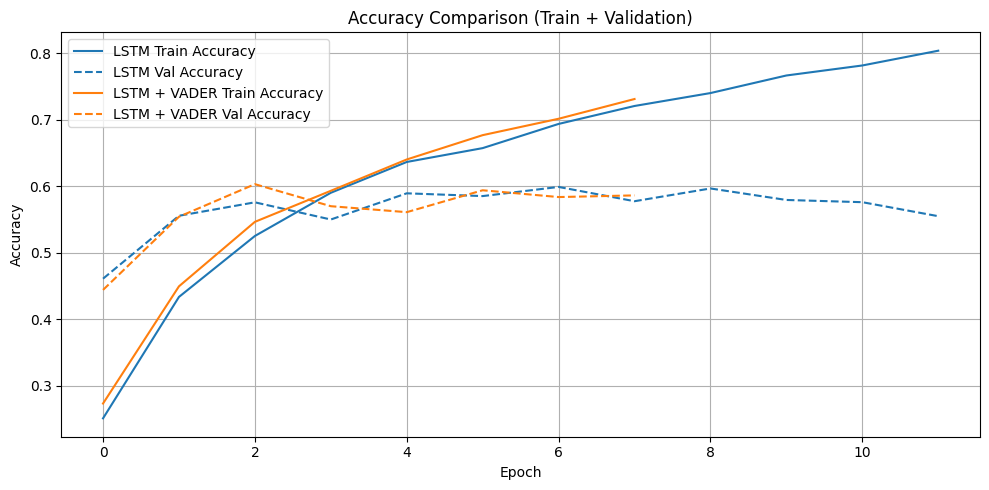

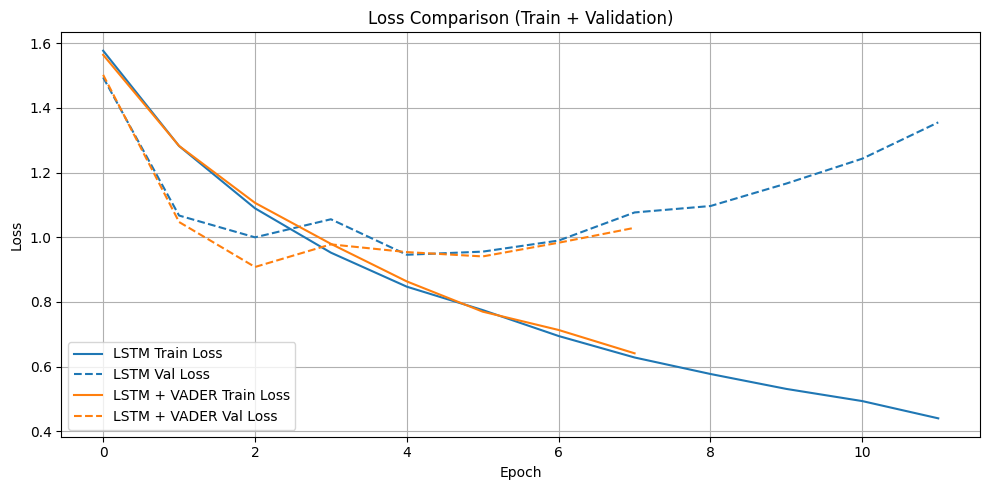

In [37]:
# Accuracy comparison (Train + Val)
plt.figure(figsize=(10, 5))

# LSTM - Blue
plt.plot(history.history['accuracy'], label='LSTM Train Accuracy', linestyle='-', color='tab:blue')
plt.plot(history.history['val_accuracy'], label='LSTM Val Accuracy', linestyle='--', color='tab:blue')

# LSTM + VADER - Orange
plt.plot(history_vader.history['accuracy'], label='LSTM + VADER Train Accuracy', linestyle='-', color='tab:orange')
plt.plot(history_vader.history['val_accuracy'], label='LSTM + VADER Val Accuracy', linestyle='--', color='tab:orange')

plt.title('Accuracy Comparison (Train + Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss comparison (Train + Val)
plt.figure(figsize=(10, 5))

# LSTM - Blue
plt.plot(history.history['loss'], label='LSTM Train Loss', linestyle='-', color='tab:blue')
plt.plot(history.history['val_loss'], label='LSTM Val Loss', linestyle='--', color='tab:blue')

# LSTM + VADER - Orange
plt.plot(history_vader.history['loss'], label='LSTM + VADER Train Loss', linestyle='-', color='tab:orange')
plt.plot(history_vader.history['val_loss'], label='LSTM + VADER Val Loss', linestyle='--', color='tab:orange')

plt.title('Loss Comparison (Train + Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
# Assign evaluation metrics of the LSTM model 
acc1 = accuracy_lstm
prec1 = precision_lstm
rec1 = recall_lstm
f1_1 = f1_lstm
auc1 = auc_lstm
                        

# LSTM with VADER prediction
y_pred_prob_vader = model_vader.predict({'text_input': X_val_seq, 'vader_input': X_val_vader})
y_pred_vader = np.argmax(y_pred_prob_vader, axis=1)
y_val_bin_vader = label_binarize(y_val_vader, classes=np.arange(5))


# LSTM with VADER model results
acc2 = accuracy_score(y_val_vader, y_pred_vader)
prec2 = precision_score(y_val_vader, y_pred_vader, average='macro')
rec2 = recall_score(y_val_vader, y_pred_vader, average='macro')
f1_2 = f1_score(y_val_vader, y_pred_vader, average='macro')
auc2 = roc_auc_score(y_val_bin_vader, y_pred_prob_vader, average='macro', multi_class='ovr')


results = [
    # {"Model": "LSTM", "Accuracy": acc1*100, "Precision": prec1*100, "Recall": rec1*100, "F1-Score": f1_1*100, "AUC": auc1*100},
    {"Model": "LSTM", "Accuracy": acc1*100, "Precision": prec1*100, "Recall": rec1*100, "F1-Score": f1_1*100, "AUC": auc1*100},
    {"Model": "LSTM + VADER", "Accuracy": acc2*100, "Precision": prec2*100, "Recall": rec2*100, "F1-Score": f1_2*100, "AUC": auc2*100}
]


results_df = pd.DataFrame(results).set_index("Model").round(2)
print("\nPerformance Comparison:")
print(results_df)

150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step

Performance Comparison:
              Accuracy  Precision  Recall  F1-Score    AUC
Model                                                     
LSTM             59.92      54.68   54.72     54.59  85.77
LSTM + VADER     60.33      55.58   55.66     55.21  86.51


#### LSTM vs. LSTM_VADER:

1. Data Description:

Across all five evaluation metrics, the LSTM + VADER model slightly outperformed the plain LSTM model:
Accuracy 60.33% (vs. 59.92%), Precision 55.58% (vs. 54.68%), Recall 55.66% (vs. 54.72%), F1-score 55.21% (vs. 54.59%), and AUC 86.51% (vs. 85.77%).

From the accuracy curves, the LSTM + VADER model converged faster in the early stages (first 5 epochs) and showed higher training accuracy, suggesting that the emotional features helped the model capture key information more quickly. On the validation set, LSTM + VADER peaked at epoch 3 (around 60.33%) and then remained relatively stable, with smoother fluctuations throughout.

The loss curves show that while both models had steadily decreasing training losses, their validation losses reached a minimum between epochs 3 and 5, then started to rise, indicating overfitting. However, the LSTM + VADER model’s validation loss increased more slowly and showed smaller fluctuations, suggesting slightly better generalization.

2. Discussion and Analysis:

VADER is a rule-based sentiment analysis tool that provides basic sentiment scores for text. In this task, sentiment may be relevant to the labels, so adding VADER scores as extra features helped the model learn faster during early training. In contrast, the plain LSTM needs to gradually learn emotional cues from data, which is less efficient.

However, since VADER only provides static and low-dimensional sentiment information, its impact becomes limited in later training stages. As a result, the final performance of LSTM + VADER largely depends on the LSTM itself, and the overall performance ends up similar to the plain LSTM model.

3. Conclusion:

Although adding VADER features did not significantly improve overall performance, it led to faster early convergence, better model stability, and slightly better results across several metrics. This suggests VADER can be a useful aid in sentiment-focused tasks. Therefore, I selected the LSTM + VADER model for final evaluation on the test set.


4. Finding:

During the experiments, I compared two settings: num_words=10000 and num_words=20000. When num_words=10000, VADER had a more noticeable impact: LSTM + VADER converged faster and was more stable than the plain LSTM. However, with num_words=20000, the difference between the two models became smaller. This is likely because the larger vocabulary allowed LSTM to learn more from the data, reducing the relative impact of VADER.

Also, when num_words=10000 was used, the model performed poorly on a new test set, with the out-of-vocabulary (OOV) rate reaching about 40%. To ensure test-time effectiveness, I finally increased the parameter to 20000 and used it as the basis for comparing both models.


### 5. Final testing on test set and discussion of results

In [40]:

# Join tokens into text (ensure the format matches training stage)
df_test_clean["tokens"] = df_test_clean["text"].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
texts_test = df_test_clean["tokens"]

# Use the same tokenizer used during training
sequences_test = tokenizer.texts_to_sequences(texts_test)
X_test_seq = pad_sequences(sequences_test, maxlen=300, padding="post", truncating="post")

# Add VADER features
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df_test_clean["vader"] = texts_test.apply(lambda x: analyzer.polarity_scores(x)["compound"])
X_test_vader = np.array(df_test_clean["vader"]).reshape(-1, 1)

# Predict using the trained model (model_vader)
y_test_pred_prob = model_vader.predict({
    "text_input": X_test_seq,
    "vader_input": X_test_vader
})
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Evaluation
if "overall_ratings" in df_test_clean.columns:
    y_test_true = df_test_clean["overall_ratings"].astype(int) - 1
    y_test_bin = label_binarize(y_test_true, classes=np.arange(5))

    acc_test = accuracy_score(y_test_true, y_test_pred)
    prec_test = precision_score(y_test_true, y_test_pred, average='macro')
    rec_test = recall_score(y_test_true, y_test_pred, average='macro')
    f1_test = f1_score(y_test_true, y_test_pred, average='macro')
    auc_test = roc_auc_score(y_test_bin, y_test_pred_prob, average='macro', multi_class='ovr')

    print("\nTest Set Evaluation Summary (Macro Average)")
    print(f"Accuracy :  {acc_test:.4f}")
    print(f"Precision:  {prec_test:.4f}")
    print(f"Recall   :  {rec_test:.4f}")
    print(f"F1-Score :  {f1_test:.4f}")
    print(f"AUC      :  {auc_test:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step

Test Set Evaluation Summary (Macro Average)
Accuracy :  0.6010
Precision:  0.4607
Recall   :  0.4728
F1-Score :  0.4636
AUC      :  0.8649


/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Final Result Discussion:
1. Data Description:
The LSTM + VADER model performed slightly worse on the test set compared to the training stage. Test accuracy was 60.1% (vs. 60.33% in training), Precision was 46.07% (vs. 55.58%), Recall was 47.28% (vs. 55.66%), F1-score was 46.36% (vs. 55.21%), and AUC was 86.49% (vs. 86.51%).

2. Possible Reasons:
	1.	Overfitting: Some overfitting was observed during training, leading to less stable performance on unseen data and a drop in overall results.
	2.	Train-test distribution difference: The training set went through EDA and additional text preprocessing, while the test set did not, limiting the model’s generalization ability.

3. Conclusion:
Although the evaluation metrics on the test set were slightly lower than during training, the AUC remained nearly the same, and other metrics showed only small differences. This suggests the model’s structure is reasonable and its prediction direction is correct.

### 6. Propose a method to predict aspects 

***(COMP SCI 7417 and COMP SCI 7717 only)***

### 7. Reflection on the ***Product*** development.

During the completion of this assignment, I found that Dive into Deep Learning and many NLP videos available online gave a clear and complete overview of the whole process of NLP tasks, including data cleaning, model training, model testing, and model checking. I also looked at the specific instructions on MyUni, and for each part, I broke it down into small steps and slowly turned them into code.

The general structure of my assignment is as follows:
1.	Data Reading and Basic Cleaning: This includes removing non-English text and strange symbols, deleting stopwords, changing all text to lowercase, and doing word lemmatization.
2.	Exploratory Data Analysis: I looked at the dataset by showing charts of the labels, text lengths, number of unique words, most common words, and rare words. I also calculated TF-IDF scores to better understand the data and decide what to do next. I wrote down my thinking process in detail for this part.
3.	Model Training and Checking: After cleaning the data, I picked KNN and Random Forest as machine learning models and LSTM as the deep learning model. I compared how well they worked using five performance scores and chose LSTM as the best one to use for testing.
4.	Model Comparison and Testing: I compared the results of the LSTM model and the LSTM model with added VADER features, and finally picked the LSTM+VADER model to test on the final dataset.

During this process, I learned the importance of balance:
1.	Balancing cost and speed: When cleaning the data, I found that many rare words were just spelling mistakes. I tried using a spell checker, but it was way too slow. So in the end, I had to give that up and just deleted those words. Some emotional words may have been lost, but since fixing them would take too much time, deleting was the only choice.
2.	Balancing computing power and time: At first, I planned to train RNN, LSTM, and GRU models and tune their settings to choose the best deep learning model. But because my computer wasn’t fast enough and time was limited, I could only focus on LSTM.
3.	Balancing the final result: In the beginning, I limited the vocabulary to the 10,000 most common words. While the charts showed that LSTM+VADER trained faster at the start, its test results were very poor. The reason was that 40% of the words in the test set didn’t appear in the training set (OOV rate too high), which made accuracy drop to just 7%. To fix this, I increased the vocabulary size to 20,000 and built one shared vocabulary using both the training and test sets. This made the difference between them smaller, dropped the OOV rate to 0.99%, and made the test results better. But doing this also meant I gave up some of the explainability I had when using the 10,000-word vocabulary, where the difference between the models was easier to see. To make sure I could finish the assignment smoothly, I chose the 20,000-word limit as a compromise.

One thing I regret is not having enough time to carefully tune the LSTM model. I noticed it was overfitting and tried to change the settings and structure, but the results were not good. In the future, I plan to deal with overfitting by using better regularization methods and picking better model settings.



### 9. References

1.	The University of Adelaide. (2025S1). Applied Natural Language Processing (COMP SCI 7417): Workshop Week 2 Notebook. The University of Adelaide.
2.	The University of Adelaide. (2025S1). Applied Natural Language Processing (COMP SCI 7417): Workshop Week 4 Notebook. The University of Adelaide.
3.	The University of Adelaide. (2025T1). Concepts in Artificial Intelligence and Machine Learning (COMP SCI 7327): Workshop 8 Practical Notebook. The University of Adelaide.
4.	Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2020). Dive into Deep Learning: Interactive deep learning book with code, math, and discussions [online]. Available at: https://d2l.ai/ [Accessed 6 Apr. 2025].
5.	Jurafsky, D. & Martin, J. H. (2023). Speech and Language Processing: An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition with Language Models (3rd ed. draft) [online]. Available at: https://web.stanford.edu/~jurafsky/slp3/ [Accessed 6 Apr. 2025].

### Appendix

In [48]:
import sys

# Create a list of packages you care about
packages = [
    "numpy", "pandas", "matplotlib", "tensorflow",
    "spacy", "nltk", "sklearn", "imblearn"
]

print("Package Version Information:\n")
for pkg in packages:
    try:
        if pkg in sys.modules:
            module = sys.modules[pkg]
            version = getattr(module, '__version__', 'No version info available')
            print(f"{pkg}: {version}")
        else:
            print(f"{pkg}: Not imported")
    except Exception as e:
        print(f"{pkg}: Failed to retrieve version info. Error: {e}")

Package Version Information:

numpy: 1.26.4
pandas: 2.2.3
matplotlib: 3.10.1
tensorflow: 2.19.0
spacy: 3.8.4
nltk: 3.9.1
sklearn: 1.6.1
imblearn: 0.13.0
